In [1]:
from math import ceil
import torch
from torch import nn

## Efficientnet スクラッチ

base_model = [
    # expand_ratio, channels, repeats, stride, kernel_size
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3],
]

phi_values = {
    # (phi_value, resolution, drop_rate)
    "b0": (0, 224, 0.2),  
    "b1": (0.5, 240, 0.2),
    "b2": (1, 260, 0.3),
    "b3": (2, 300, 0.3),
    "b4": (3, 380, 0.4),
    "b5": (4, 456, 0.4),
    "b6": (5, 528, 0.5),
    "b7": (6, 600, 0.5),
}

class CNNBlock(nn.Module):
  def __init__(self, in_channels, out_channels,
               kernel_size, stride, padding, groups=1):
    super(CNNBlock, self).__init__()
    # もしgoups=1なら通常のconv, goups=inchannelsならdepthwiseconvになる。
    self.cnn = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, groups=groups, bias=False)
    self.bn = nn.BatchNorm2d(out_channels)
    self.silu = nn.SiLU() # SiLUとSwish同じ。

  def forward(self, x):
    return self.silu(self.bn(self.cnn(x)))


class SqueezeExcitation(nn.Module):
  def __init__(self, in_channels, reduced_dim):
    super(SqueezeExcitation, self).__init__()
    self.se = nn.Sequential(
        nn.AdaptiveAvgPool2d(1), # C x H x W -> C x 1 x 1
        nn.Conv2d(in_channels, reduced_dim, 1),
        nn.SiLU(),
        nn.Conv2d(reduced_dim, in_channels, 1),
        nn.Sigmoid(),
    )

  def forward(self, x):
    return x * self.se(x)


class InvertedResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size,
               stride, padding, expand_ratio, reduction=4, survival_prob=0.8):
    super(InvertedResidualBlock, self).__init__()
    self.survival_prob = 0.8
    self.use_residual = in_channels == out_channels and stride == 1 # 論文で言う繰り返されるstageで、2回目からTrueになる。
    hidden_dim = in_channels * expand_ratio
    self.expand = in_channels != hidden_dim
    reduced_dim = int(in_channels / reduction)

    if self.expand:
      self.expand_conv = CNNBlock(
          in_channels, hidden_dim, kernel_size=3, stride=1, padding=1
      )
    self.conv = nn.Sequential(
        CNNBlock(
            hidden_dim, hidden_dim, kernel_size, stride, padding, groups=hidden_dim,
        ),
        SqueezeExcitation(hidden_dim, reduced_dim),
        nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
        nn.BatchNorm2d(out_channels),
    )

  def stochastic_depth(self, x):
    if not self.training:
      return x

    binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.survival_prob
    return torch.div(x, self.survival_prob) * binary_tensor

  def forward(self, inputs):
    x = self.expand_conv(inputs) if self.expand else inputs

    if self.use_residual:
      return self.stochastic_depth(self.conv(x)) + inputs
    else:
      return self.conv(x)


class EfficientNet(nn.Module):
  def __init__(self, version, num_classes):
    super(EfficientNet, self).__init__()
    width_factor, depth_factor, dropout_rate = self.calculate_factors(version)
    last_channels = ceil(1280 * width_factor) # ceilは与えた数以上の最小の整数を返す. ceil(.95) -> 1
    self.pool = nn.AdaptiveAvgPool2d(1)
    self.features = self.create_features(width_factor, depth_factor, last_channels)
    self.classifier = nn.Sequential(
        nn.Dropout(dropout_rate),
        nn.Linear(last_channels, num_classes),
    )

  def calculate_factors(self, version, alpha=1.2, beta=1.1):
    phi, res, drop_rate = phi_values[version]
    depth_factor = alpha ** phi
    width_factor = beta ** phi
    return width_factor, depth_factor, drop_rate

  def create_features(self, width_factor, depth_factor, last_channels):
    channels = int(32 * width_factor)
    features = [CNNBlock(3, channels, 3, stride=2, padding=1)]
    in_channels = channels

    for expand_ratio, channels, repeats, stride, kernel_size in base_model:
      out_channels = 4*ceil(int(channels*width_factor) / 4)
      layers_repeats = ceil(repeats * depth_factor)

      for layer in range(layers_repeats):
        features.append(
            InvertedResidualBlock(
                in_channels,
                out_channels,
                expand_ratio=expand_ratio,
                stride = stride if layer == 0 else 1, # layer0以外では、H,Wが変わらないようにしている。
                kernel_size=kernel_size,
                padding=kernel_size//2, # H,Wが変わらないようにしている。
            )
        )
        in_channels = out_channels
    features.append(
        CNNBlock(in_channels, last_channels, kernel_size=1, stride=1, padding=0)
    )

    return nn.Sequential(*features)

  def forward(self, x):
    x = self.pool(self.features(x))
    return self.classifier(x.view(x.shape[0], -1))


def test():
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  version = 'b0'
  phi, res, drop_rate = phi_values[version]
  num_examples, num_classes = 4, 10
  x = torch.randn((num_examples, 3, res, res)).to(device)
  model = EfficientNet(
      version=version,
      num_classes = num_classes,
  ).to(device)
  
  result = model(x)
  print(result.shape) # (num_examples, num_classes)

test()

torch.Size([4, 10])


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import os
from glob import glob
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import numpy as np
from datetime import datetime
import pandas as pd
import random 
from torchvision.datasets import ImageFolder
import re
import math
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import roc_auc_score
from skimage.io import imread, imsave
import skimage
from PIL import ImageFile
from PIL import Image
torch.cuda.empty_cache()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
a = glob('drive/MyDrive/Lung_Nodule_2/Image_Processed_2/Nodule/*')
b = glob('drive/MyDrive/Lung_Nodule_2/Image_Processed_2/Not_Nodule/*')

# 結節ありの画像(a)と、なしの画像(b)の枚数を確認。
len(a), len(b)

(448, 598)

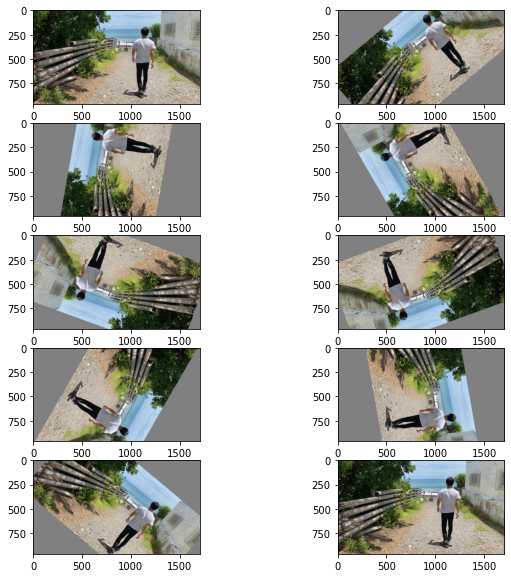

how  to test


In [4]:
## Rand Augment

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageEnhance, ImageOps
import numpy as np
import random


class Rand_Augment():
    def __init__(self, Numbers=None, max_Magnitude=None):
        self.transforms = ['autocontrast', 'equalize', 'rotate', 'solarize', 'color', 'posterize',
                           'contrast', 'brightness', 'sharpness', 'shearX', 'shearY', 'translateX', 'translateY']
        if Numbers is None:
            self.Numbers = len(self.transforms) // 2
        else:
            self.Numbers = Numbers
        if max_Magnitude is None:
            self.max_Magnitude = 10
        else:
            self.max_Magnitude = max_Magnitude
        fillcolor = 128
        self.ranges = {
            # these  Magnitude   range , you  must test  it  yourself , see  what  will happen  after these  operation ,
            # it is no  need to obey  the value  in  autoaugment.py
            "shearX": np.linspace(0, 0.3, 10),
            "shearY": np.linspace(0, 0.3, 10),
            "translateX": np.linspace(0, 0.2, 10),
            "translateY": np.linspace(0, 0.2, 10),
            "rotate": np.linspace(0, 360, 10),
            "color": np.linspace(0.0, 0.9, 10),
            "posterize": np.round(np.linspace(8, 4, 10), 0).astype(np.int),
            "solarize": np.linspace(256, 231, 10),
            "contrast": np.linspace(0.0, 0.5, 10),
            "sharpness": np.linspace(0.0, 0.9, 10),
            "brightness": np.linspace(0.0, 0.3, 10),
            "autocontrast": [0] * 10,
            "equalize": [0] * 10,           
            "invert": [0] * 10
        }
        self.func = {
            "shearX": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, magnitude * random.choice([-1, 1]), 0, 0, 1, 0),
                Image.BICUBIC, fill=fillcolor),
            "shearY": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, 0, magnitude * random.choice([-1, 1]), 1, 0),
                Image.BICUBIC, fill=fillcolor),
            "translateX": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, magnitude * img.size[0] * random.choice([-1, 1]), 0, 1, 0),
                fill=fillcolor),
            "translateY": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, 0, 0, 1, magnitude * img.size[1] * random.choice([-1, 1])),
                fill=fillcolor),
            "rotate": lambda img, magnitude: self.rotate_with_fill(img, magnitude),
            # "rotate": lambda img, magnitude: img.rotate(magnitude * random.choice([-1, 1])),
            "color": lambda img, magnitude: ImageEnhance.Color(img).enhance(1 + magnitude * random.choice([-1, 1])),
            "posterize": lambda img, magnitude: ImageOps.posterize(img, magnitude),
            "solarize": lambda img, magnitude: ImageOps.solarize(img, magnitude),
            "contrast": lambda img, magnitude: ImageEnhance.Contrast(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "sharpness": lambda img, magnitude: ImageEnhance.Sharpness(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "brightness": lambda img, magnitude: ImageEnhance.Brightness(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "autocontrast": lambda img, magnitude: ImageOps.autocontrast(img),
            "equalize": lambda img, magnitude: img,
            "invert": lambda img, magnitude: ImageOps.invert(img)
        }

    def rand_augment(self):
        """Generate a set of distortions.
             Args:
             N: Number of augmentation transformations to apply sequentially. N  is len(transforms)/2  will be best
             M: Max_Magnitude for all the transformations. should be  <= self.max_Magnitude """

        M = np.random.randint(0, self.max_Magnitude, self.Numbers)

        sampled_ops = np.random.choice(self.transforms, self.Numbers)
        return [(op, Magnitude) for (op, Magnitude) in zip(sampled_ops, M)]

    def __call__(self, image):
        operations = self.rand_augment()
        for (op_name, M) in operations:
            operation = self.func[op_name]
            mag = self.ranges[op_name][M]
            image = operation(image, mag)
        return image

    def rotate_with_fill(self, img, magnitude):
        #  I  don't know why  rotate  must change to RGBA , it is  copy  from Autoaugment - pytorch
        rot = img.convert("RGBA").rotate(magnitude)
        return Image.composite(rot, Image.new("RGBA", rot.size, (128,) * 4), rot).convert(img.mode)

    def test_single_operation(self, image, op_name, M=-1):
        '''
        :param image: image
        :param op_name: operation name in   self.transforms
        :param M: -1  stands  for the  max   Magnitude  in  there operation
        :return:
        '''
        operation = self.func[op_name]
        mag = self.ranges[op_name][M]
        image = operation(image, mag)
        return image


if __name__ == '__main__':
    # # this  is  for  call the whole fun
    # img_augment = Rand_Augment()
    # img_origal = Image.open(r'0a38b552372d.png')
    # img_final = img_augment(img_origal)
    # plt.imshow(img_final)
    # plt.show()
    # print('how to  call')

    # this  is for  a  single  fun  you  want to test
    img_augment = Rand_Augment()
    img_origal = Image.open('drive/MyDrive/instagram写真/line_2152454813573294.jpg')
    fig, ax = plt.subplots(5, 2, figsize=(10, 10))
    for i in range(0, 10):
        img_final = img_augment.test_single_operation(img_origal, 'rotate', M=i)
        ax[i//2, i%2].imshow(img_final)
    plt.show()
    print('how  to test')

In [5]:
## trainデータセットの平均と標準偏差を使用。
normalize = transforms.Normalize(mean=[0.4305, 0.4305, 0.4305],
                                     std=[0.3505, 0.3505, 0.3505])

train_transformer = transforms.Compose([
    transforms.Resize((260, 260)),
    # transforms.RandomResizedCrop((224),scale=(0.5,1.0)),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(90),
    # random brightness and random contrast 
    # brightness:明るさ, contrast:コントラスト, saturation:彩度, hue:色相
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=3),
    transforms.ToTensor(),
    normalize,
])

val_transformer = transforms.Compose([
    # transforms.Resize((600, 600)),
    transforms.Resize((260, 260)),
    transforms.ToTensor(),
    normalize,
])

In [7]:
batchsize = 6
def read_txt(txt_path):
    with open(txt_path) as f:
        lines = f.readlines()
    txt_data = [line.strip() for line in lines]
    return txt_data

class NoduleCTDataset(Dataset):
    def __init__(self, root_dir, txt_Nodule, txt_Non_Nodule, transform=None, rand_augment=None):
        self.root_dir = root_dir
        self.txt_path = [txt_Nodule,txt_Non_Nodule]
        self.classes = ['Nodule', 'Not_Nodule']
        self.num_cls = len(self.classes)
        self.img_list = []
        for c in range(self.num_cls):

                                                                          # ここの c が正解ラベル！！！！
            cls_list = [[os.path.join(self.root_dir,self.classes[c],item), c] for item in read_txt(self.txt_path[c])]

            self.img_list += cls_list
        self.rand_augment = rand_augment
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_path = self.img_list[idx][0]
        # RGBで呼び出す必要はある？
        image = Image.open(img_path).convert('RGB')
        if self.rand_augment:
          image = self.rand_augment.__call__(image)

        if self.transform:
            image = self.transform(image)
        sample = {'img': image,
                  'label': int(self.img_list[idx][1])}
        return sample



    
if __name__ == '__main__':
    trainset = NoduleCTDataset(root_dir='drive/MyDrive/Lung_Nodule_2/Image_Processed_2/',
                              txt_Nodule='drive/MyDrive/Lung_Nodule_2/Data_Split_2/train_nodule.txt',
                              txt_Non_Nodule='drive/MyDrive/Lung_Nodule_2/Data_Split_2/train_not_nodule.txt',
                              transform=train_transformer,
                              rand_augment=Rand_Augment(Numbers=1, max_Magnitude=5))
    valset = NoduleCTDataset(root_dir='drive/MyDrive/Lung_Nodule_2/Image_Processed_2/',
                              txt_Nodule='drive/MyDrive/Lung_Nodule_2/Data_Split_2/val_nodule.txt',
                              txt_Non_Nodule='drive/MyDrive/Lung_Nodule_2/Data_Split_2/val_not_nodule.txt',
                              transform=val_transformer)
    testset = NoduleCTDataset(root_dir='drive/MyDrive/Lung_Nodule_2/Image_Processed_2/',
                              txt_Nodule='drive/MyDrive/Lung_Nodule_2/Data_Split_2/test_nodule.txt',
                              txt_Non_Nodule='drive/MyDrive/Lung_Nodule_2/Data_Split_2/test_not_nodule.txt',
                              transform=val_transformer)
    
    print('{}'.format(trainset.__len__()))
    print('{}'.format(valset.__len__()))
    print('{}'.format(testset.__len__()))

    train_loader = DataLoader(trainset, batch_size=batchsize, drop_last=False, shuffle=True)
    val_loader = DataLoader(valset, batch_size=batchsize, drop_last=False, shuffle=False)
    test_loader = DataLoader(testset, batch_size=batchsize, drop_last=False, shuffle=False)
    

  

646
160
90


In [16]:
batch_data = next(iter(train_loader))
data = batch_data['img']
label = batch_data['label']
data.shape

torch.Size([6, 3, 260, 260])

Text(0.5, 0, '1')

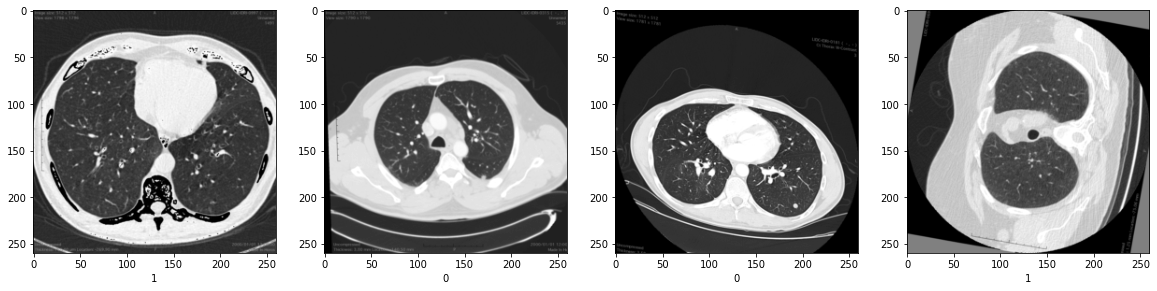

In [17]:
fig, ax = plt.subplots(1,4,figsize=(20,40))
ax[0].imshow(data[0,0,:,:], cmap='gray')
ax[0].set_xlabel('{}'.format(label[0]))

ax[1].imshow(data[1,0,:,:], cmap='gray')
ax[1].set_xlabel('{}'.format(label[1]))

ax[2].imshow(data[2,0,:,:], cmap='gray')
ax[2].set_xlabel('{}'.format(label[2]))

ax[3].imshow(data[3,0,:,:], cmap='gray')
ax[3].set_xlabel('{}'.format(label[3]))


In [18]:
# mixup

def mixup_data(x, y, alpha=1.0, use_cuda=True):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
        # print('lam',lam)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda() # torch.randperm(4) -> 例)tensor[2, 1, 3, 4]
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    # print(pred)
    # print(y_a)
    # print('criterion',criterion(pred, y_a))
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [19]:
#training process 

alpha = 1
# alpah = None

## mixupを使わないなら、alpha = None
device = 'cuda'

def train(optimizer, epoch):
    # print(epoch)
    
    model.train()
    # writer = SummaryWriter()

    train_loss = 0
    train_correct = 0
    # if tfboard_dir:
    #   from tensorboardX import SummaryWriter
    #   tblogger = SummaryWriter(tfboard_dir)

    
    for batch_index, batch_samples in enumerate(train_loader):
        
        data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)   
        
        #mixup
        data, targets_a, targets_b, lam = mixup_data(data, target, alpha, use_cuda=True)
        
        
        optimizer.zero_grad()
        output = model(data)
        criteria = nn.CrossEntropyLoss()
        # loss = criteria(output, target.long())

        #mixup loss
        loss = mixup_criterion(criteria, output, targets_a, targets_b, lam)

        train_loss += criteria(output, targets_b.long())
        # train_loss += loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        pred = output.argmax(dim=1, keepdim=True)
        train_correct += pred.eq(target.long().view_as(pred)).sum().item()
    
        if batch_index % bs == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}'.format(
              epoch, batch_index, len(train_loader),
              100.0 * batch_index / len(train_loader), loss.item()/ bs))
          
    return train_loss.item() / (len(train_loader)* 4)  # 4はバッチサイズ
       

In [20]:
#val process

def val(epoch):
    
    model.eval()
    test_loss = 0
    correct = 0
    results = []
    
    TP = 0
    TN = 0
    FN = 0
    FP = 0
    
    
    criteria = nn.CrossEntropyLoss()
    # モデルをアップデートしない！
    with torch.no_grad():
        tpr_list = []
        fpr_list = []
        
        predlist=[]
        scorelist=[]
        targetlist=[]
        # Predict
        for batch_index, batch_samples in enumerate(val_loader):
            data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)
            
#             data = data[:, 0, :, :]
#             data = data[:, None, :, :]
            output = model(data)
            
            test_loss += criteria(output, target.long())
            score = F.softmax(output, dim=1)
            pred = output.argmax(dim=1, keepdim=True)
#             print('target',target.long()[:, 2].view_as(pred))
            correct += pred.eq(target.long().view_as(pred)).sum().item()
            
#             print(output[:,1].cpu().numpy())
#             print((output[:,1]+output[:,0]).cpu().numpy())
#             predcpu=(output[:,1].cpu().numpy())/((output[:,1]+output[:,0]).cpu().numpy())
            targetcpu=target.long().cpu().numpy()
            predlist=np.append(predlist, pred.cpu().numpy())
            scorelist=np.append(scorelist, score.cpu().numpy()[:,1])
            targetlist=np.append(targetlist,targetcpu)
           
    return targetlist, scorelist, predlist, test_loss.item()/(len(val_loader)* 4)  #4はバッチサイズ
    
    # Write to tensorboard
#     writer.add_scalar('Test Accuracy', 100.0 * correct / len(test_loader.dataset), epoch)

In [21]:
#test process 

def test(epoch):
    
    model.eval()
    test_loss = 0
    correct = 0
    results = []
    
    TP = 0
    TN = 0
    FN = 0
    FP = 0
    
    
    criteria = nn.CrossEntropyLoss()
    # モデルをアップデートしない。
    with torch.no_grad():
        tpr_list = []
        fpr_list = []
        
        predlist=[]
        scorelist=[]
        targetlist=[]
        # Predict
        for batch_index, batch_samples in enumerate(test_loader):
            data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)
#             data = data[:, 0, :, :]
#             data = data[:, None, :, :]
#             print(target)
            output = model(data)
            
            test_loss += criteria(output, target.long())
            score = F.softmax(output, dim=1)
            pred = output.argmax(dim=1, keepdim=True)
#             print('target',target.long()[:, 2].view_as(pred))
            correct += pred.eq(target.long().view_as(pred)).sum().item()
#             TP += ((pred == 1) & (target.long()[:, 2].view_as(pred).data == 1)).cpu().sum()
#             TN += ((pred == 0) & (target.long()[:, 2].view_as(pred) == 0)).cpu().sum()
# #             # FN    predict 0 label 1
#             FN += ((pred == 0) & (target.long()[:, 2].view_as(pred) == 1)).cpu().sum()
# #             # FP    predict 1 label 0
#             FP += ((pred == 1) & (target.long()[:, 2].view_as(pred) == 0)).cpu().sum()
#             print(TP,TN,FN,FP)
            
            
#             print(output[:,1].cpu().numpy())
#             print((output[:,1]+output[:,0]).cpu().numpy())
#             predcpu=(output[:,1].cpu().numpy())/((output[:,1]+output[:,0]).cpu().numpy())
            targetcpu=target.long().cpu().numpy()
            predlist=np.append(predlist, pred.cpu().numpy())
            scorelist=np.append(scorelist, score.cpu().numpy()[:,1])
            targetlist=np.append(targetlist,targetcpu)
    return targetlist, scorelist, predlist
    
    # Write to tensorboard
#     writer.add_scalar('Test Accuracy', 100.0 * correct / len(test_loader.dataset), epoch)

In [ ]:
# '''DenseNet121 pretrained model from xrv'''

# class DenseNetModel(nn.Module):

#     def __init__(self):
#         """
#         Pass in parsed HyperOptArgumentParser to the model
#         :param hparams:
#         """
#         super(DenseNetModel, self).__init__()

#         self.dense_net = xrv.models.DenseNet(num_classes=2)
#         self.criterion = nn.CrossEntropyLoss()

#     def forward(self, x):
#         logits = self.dense_net(x)
#         return logits
  
# model = DenseNetModel().cuda()
# modelname = 'DenseNet_medical'
# # print(model)

In [ ]:
'''ResNet18 pretrained'''
import torchvision.models as models
model = models.resnet18(pretrained=True).cuda()
modelname = 'ResNet18'

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
# '''Dense121 pretrained'''
import torchvision.models as models
model = models.densenet121(pretrained=True)
modelname = 'Dense121'
# pretrained_net = torch.load('')
# model.load_state_dict(pretrained_net)

In [ ]:
### Dense169
import torchvision.models as models
model = models.densenet169(pretrained=True).cuda()
modelname = 'Dense169'

# """load MoCo pretrained model"""
# checkpoint = torch.load('new_data/save_model_dense/checkpoint_luna_covid_moco.pth.tar')
# # # # print(checkpoint.keys())
# # # # print(checkpoint['arch'])

# state_dict = checkpoint['state_dict']
# for key in list(state_dict.keys()):
#     if 'module.encoder_q' in key:
# #         print(key[17:])
#         new_key = key[17:]
#         state_dict[new_key] = state_dict[key]
#     del state_dict[key]
# for key in list(state_dict.keys()):
#     if  key == 'classifier.0.weight':
#         new_key = 'classifier.weight'
#         state_dict[new_key] = state_dict[key]
#         del state_dict[key]
#     if  key == 'classifier.0.bias':
#         new_key = 'classifier.bias'
#         state_dict[new_key] = state_dict[key]
#         del state_dict[key]
#     if  key == 'classifier.2.weight' or key == 'classifier.2.bias':
#         del state_dict[key]
# state_dict['classifier.weight'] = state_dict['classifier.weight'][:1000,:]
# state_dict['classifier.bias'] = state_dict['classifier.bias'][:1000]
# model.load_state_dict(checkpoint['state_dict'])

# # # print(model)

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth


  0%|          | 0.00/54.7M [00:00<?, ?B/s]

In [ ]:
# """Load Self-Trans model"""
# """Change names and locations to the Self-Trans.pt"""


# model = models.densenet169(pretrained=True).cuda()
# # pretrained_net = torch.load('model_backup/Dense169.pt')
# # pretrained_net = torch.load('model_backup/mixup/Dense169_0.6.pt')
# pretrained_net = torch.load('model_backup/medical_transfer/medical_transfer_None_LUNA_moco_covid_moco.pt')


# model.load_state_dict(pretrained_net)

# modelname = 'Dense169_ssl_luna_moco'

In [ ]:
'''ResNet50 pretrained'''

import torchvision.models as models
model = models.resnet50(pretrained=True).cuda()

# checkpoint = torch.load('new_data/save_model/checkpoint.pth.tar')
# # print(checkpoint.keys())
# # print(checkpoint['arch'])

# state_dict = checkpoint['state_dict']
# for key in list(state_dict.keys()):
#     if 'module.encoder_q' in key:
#         print(key[17:])
#         new_key = key[17:]
#         state_dict[new_key] = state_dict[key]
#     del state_dict[key]
# for key in list(state_dict.keys()):
#     if  key == 'fc.0.weight':
#         new_key = 'fc.weight'
#         state_dict[new_key] = state_dict[key]
#         del state_dict[key]
#     if  key == 'fc.0.bias':
#         new_key = 'fc.bias'
#         state_dict[new_key] = state_dict[key]
#         del state_dict[key]
#     if  key == 'fc.2.weight' or key == 'fc.2.bias':
#         del state_dict[key]
# state_dict['fc.weight'] = state_dict['fc.weight'][:1000,:]
# state_dict['fc.bias'] = state_dict['fc.bias'][:1000]
# # print(state_dict.keys())

# # print(state_dict)
# # pattern = re.compile(
# #         r'^(.*denselayer\d+\.(?:norm|relu|conv))\.((?:[12])\.(?:weight|bias|running_mean|running_var))$')
# #     for key in list(state_dict.keys()):
# #         match = pattern.match(key)
# #         new_key = match.group(1) + match.group(2) if match else key
# #         new_key = new_key[7:] if remove_data_parallel else new_key
# #         new_key = new_key[7:]
# #         state_dict[new_key] = state_dict[key]
# #         del state_dict[key]
    
# # model.load_state_dict(checkpoint['state_dict'])
    
# # # # modelname = 'ResNet50'
modelname = 'ResNet50_ssl'

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
'''VGGNet pretrained'''
import torchvision.models as models
model = models.vgg16(pretrained=True)
model = model.cuda()
modelname = 'vgg16'

In [ ]:
# '''efficientNet pretrained b0'''

! pip install efficientnet_pytorch 

from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=2)
model = model.cuda()
modelname = 'efficientNet-b0'


# model = EfficientNet.from_name('efficientnet-b1').cuda()
# modelname = 'efficientNet_random'

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0


In [22]:
# '''efficientNet pretrained b2'''

! pip install efficientnet_pytorch 

from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b2', num_classes=2)
model = model.cuda()
modelname = 'efficientNet-b2'


# model = EfficientNet.from_name('efficientnet-b1').cuda()
# modelname = 'efficientNet_random'

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=b16239dbfdb9f093c2944aee077e968c8fff812939eb08661ec6fdc74550b101
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth


  0%|          | 0.00/35.1M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b2


In [ ]:
# '''efficientNet pretrained b7'''

! pip install efficientnet_pytorch 

from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b7', num_classes=2)
model = model.cuda()
modelname = 'efficientNet-b7'


# model = EfficientNet.from_name('efficientnet-b1').cuda()
# modelname = 'efficientNet_random'

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=d22eda4dfa985aa0d4261001eae1bdd3eb44411b890c369277df93b73f74031b
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth


  0%|          | 0.00/254M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b7


In [ ]:
# ! pip install tensorboardX
# # colabでtensorboardを使うには、以下の文やマジックコマンドが必要。
# from __future__ import absolute_import, division, print_function, unicode_literals

# try:
#   %tensorflow_version only exists in Colab.
#   %tensorflow_version 2.x
# except Exception:
#   pass

# %load_ext tensorboard


In [24]:
# train

loss_train = []
loss_val = []

bs = batchsize
total_epoch = 200


votenum = 100
checkpoint_interval = 20
checkpoint_dir = 'drive/MyDrive/Checkpoint_CT'

import warnings
warnings.filterwarnings('ignore')

logs_dir = 'drive/MyDrive/CT-Logs'
# from tensorboardX import SummaryWriter
# writer = SummaryWriter(logs_dir)

#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum = 0.9)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.95)
                                             
scheduler = StepLR(optimizer, step_size=1)


# checkpointファイルがあれば、パスを記載。
checkpoint = None
# checkpoint = 'drive/MyDrive/Checkpoint_CT/snapshot180.ckpt'

iter_state = 1
if checkpoint:
  print('loading pytorch ckpt...', checkpoint)
  state = torch.load(checkpoint)

  if 'model_state_dict' in state.keys():
    model.load_state_dict(state['model_state_dict'])
  else:
    model.load_state_dict(state)

if checkpoint:
  if 'optimizer_state_dict' in state.keys():
    optimizer.load_state_dict(state['optimizer_state_dict'])
    iter_state = state['epoch'] + 1


r_list = []
p_list = []
acc_list = []
AUC_list = []
# TP = 0
# TN = 0
# FN = 0
# FP = 0
vote_pred = np.zeros(valset.__len__())
vote_score = np.zeros(valset.__len__())


for epoch in range(iter_state, iter_state + total_epoch if iter_state == 1 else iter_state + total_epoch + 1):
    
    train_lo = train(optimizer, epoch)
    # writer.add_scalar('train_loss', train_lo, epoch)

    targetlist, scorelist, predlist, val_lo = val(epoch)
    # writer.add_scalar('val_loss', val_lo, epoch)
    # print('target',targetlist)
    # print('score',scorelist)
    # print('predict',predlist)
    vote_pred = vote_pred + predlist 
    vote_score = vote_score + scorelist 

    loss_train.append(train_lo)
    loss_val.append(val_lo)
    

    if epoch % votenum == 0:
        
        # major vote
        vote_pred[vote_pred <= (votenum/2)] = 0
        vote_pred[vote_pred > (votenum/2)] = 1
        vote_score = vote_score/votenum
        
        print('vote_pred', vote_pred)
        print('targetlist', targetlist)
        TP = ((vote_pred == 1) & (targetlist == 1)).sum()
        TN = ((vote_pred == 0) & (targetlist == 0)).sum()
        FN = ((vote_pred == 0) & (targetlist == 1)).sum()
        FP = ((vote_pred == 1) & (targetlist == 0)).sum()
        
        
        print('TP=',TP,'TN=',TN,'FN=',FN,'FP=',FP)
        print('TP+FP',TP+FP)
        p = TP / (TP + FP)
        print('precision',p)
        p = TP / (TP + FP)
        r = TP / (TP + FN)
        print('recall',r)
        F1 = 2 * r * p / (r + p)
        acc = (TP + TN) / (TP + TN + FP + FN)
        print('F1',F1)
        print('acc',acc)
        AUC = roc_auc_score(targetlist, vote_score)
        print('AUCp', roc_auc_score(targetlist, vote_pred))
        print('AUC', AUC)
        
        
        
#         if epoch == total_epoch:
        # torch.s_ave(model.state_dict(), "model_backup/medical_transfer/{}_{}_covid_moco_covid.pt".format(modelname,alpha_name))  
        
        vote_pred = np.zeros(valset.__len__())
        vote_score = np.zeros(valset.__len__())
        print('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},\
average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(
        epoch, r, p, F1, acc, AUC))
        print(modelname)

    if epoch > 0 and (epoch % checkpoint_interval == 0):
      torch.save({'epoch': epoch,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  },
                 os.path.join(checkpoint_dir, 'snapshot'+str(epoch)+'.ckpt'))
      # lossを記録
      with open('drive/MyDrive/train_loss.txt', 'w') as f:
        for i in range(len(loss_train)):
          f.write('{}{}'.format(str(loss_train[i]), '\n'))

      with open('drive/MyDrive/val_loss.txt', 'w') as f:
        for i in range(len(loss_val)):
          f.write('{}{}'.format(str(loss_val[i]), '\n'))

#         f = open('model_result/medical_transfer/{}_{}.txt'.format(modelname,alpha_name), 'a+')
#         f.write('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},\
# average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(
#         epoch, r, p, F1, acc, AUC))
#         f.close()

# writer.close()


Train Epoch: 1 [0/108 (0%)]	Train Loss: 0.119509
Train Epoch: 1 [6/108 (6%)]	Train Loss: 0.115111
Train Epoch: 1 [12/108 (11%)]	Train Loss: 0.107411
Train Epoch: 1 [18/108 (17%)]	Train Loss: 0.133569
Train Epoch: 1 [24/108 (22%)]	Train Loss: 0.094978
Train Epoch: 1 [30/108 (28%)]	Train Loss: 0.100506
Train Epoch: 1 [36/108 (33%)]	Train Loss: 0.095153
Train Epoch: 1 [42/108 (39%)]	Train Loss: 0.105756
Train Epoch: 1 [48/108 (44%)]	Train Loss: 0.080836
Train Epoch: 1 [54/108 (50%)]	Train Loss: 0.126420
Train Epoch: 1 [60/108 (56%)]	Train Loss: 0.089119
Train Epoch: 1 [66/108 (61%)]	Train Loss: 0.095920
Train Epoch: 1 [72/108 (67%)]	Train Loss: 0.125219
Train Epoch: 1 [78/108 (72%)]	Train Loss: 0.130643
Train Epoch: 1 [84/108 (78%)]	Train Loss: 0.112917
Train Epoch: 1 [90/108 (83%)]	Train Loss: 0.113025
Train Epoch: 1 [96/108 (89%)]	Train Loss: 0.069273
Train Epoch: 1 [102/108 (94%)]	Train Loss: 0.128161
Train Epoch: 2 [0/108 (0%)]	Train Loss: 0.093801
Train Epoch: 2 [6/108 (6%)]	Train Lo

In [ ]:
with open('drive/MyDrive/param.txt', 'r') as f:
  a = f.readlines()
a = [int(i.strip()) for i in a]
a

[1, 2, 3]

In [ ]:
loss_train = torch.rand(200)
loss_val = torch.rand(200)
epoch = torch.range(1, 200)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  This is separate from the ipykernel package so we can avoid doing imports until


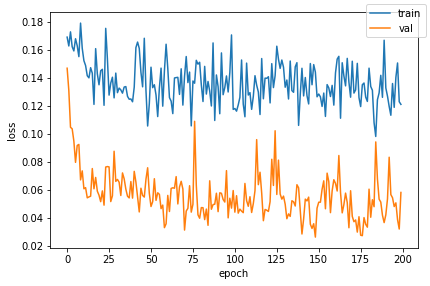

In [25]:
fig, ax = plt.subplots()
ax.plot(loss_train, label='train')
ax.plot(loss_val, label='val')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

# ax[1].plot(loss_val)
# ax[1].set_xlabel('epoch')
# ax[1].set_ylabel('val_loss')

fig.tight_layout()
fig.legend()

fig.savefig('drive/MyDrive/Checkpoint_CT/')

In [ ]:
# %tensorboard --logdir=drive/MyDrive/CT-Logs

In [26]:
# モデルをロード
state = torch.load('drive/MyDrive/Checkpoint_CT/snapshot200.ckpt')
model.load_state_dict(state['model_state_dict'])

<All keys matched successfully>

In [ ]:
# test
bs = 10
import warnings
warnings.filterwarnings('ignore')

epoch = 1
r_list = []
p_list = []
acc_list = []
AUC_list = []
# TP = 0
# TN = 0
# FN = 0
# FP = 0
vote_pred = np.zeros(testset.__len__())
vote_score = np.zeros(testset.__len__())


targetlist, scorelist, predlist = test(epoch)
print('target',targetlist)
print('score',scorelist)
print('predict',predlist)
vote_pred = vote_pred + predlist 
vote_score = vote_score + scorelist 

TP = ((predlist == 1) & (targetlist == 1)).sum()

TN = ((predlist == 0) & (targetlist == 0)).sum()
FN = ((predlist == 0) & (targetlist == 1)).sum()
FP = ((predlist == 1) & (targetlist == 0)).sum()

print('TP=',TP,'TN=',TN,'FN=',FN,'FP=',FP)
print('TP+FP',TP+FP)
p = TP / (TP + FP)
print('precision',p)
p = TP / (TP + FP)
r = TP / (TP + FN)
print('recall',r)
F1 = 2 * r * p / (r + p)
acc = (TP + TN) / (TP + TN + FP + FN)
print('F1',F1)
print('acc',acc)
AUC = roc_auc_score(targetlist, vote_score)
print('AUC', AUC)

# f = open(f'model_result/medical_transfer/test_{modelname}_{alpha_name}_LUNA_moco_CT_moco.txt', 'a+')
# f.write('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},\
# average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(
# epoch, r, p, F1, acc, AUC))
# f.close()
# torch.save(model.state_dict(), "model_backup/medical_transfer/{}_{}_covid_moco_covid.pt".format(modelname,alpha_name))


target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [4.93930944e-04 3.77357828e-05 1.35399881e-04 9.76288793e-05
 2.52418067e-05 1.82142144e-03 1.89322210e-03 4.89345166e-06
 4.11075260e-03 2.75897881e-04 7.16144621e-01 3.21166939e-03
 8.89944315e-01 3.83699953e-04 4.17302400e-02 1.01667782e-03
 3.96374729e-04 4.50144475e-03 3.98509912e-02 9.08546906e-04
 1.91420841e-03 3.18883895e-03 5.33576459e-02 4.81020622e-02
 9.99699831e-01 6.47088587e-01 2.84052501e-03 3.65577661e-03
 2.77635354e-05 1.49969332e-04 9.97042120e-01 2.67816205e-02
 2.64228553e-01 2.10770275e-02 2.18841771e-04 1.75984297e-03
 2.85669885e-05 1.44366780e-03 4.40681679e-03 4.14688926e-04
 4.46974707e-04 2.22066737e-05 1.26329818e-04 1.70971689e-05
 5.51757403e-02 9.99375165e-01 2.92146742